# Data science practical
In this data science tutorial we will reporoduce some of the analysis from "A Validated Prediction Model for Overall 
Survival From Stage III Non-Small Cell Lung Cancer: Toward Survival Prediction for Individual Patients" from the Maastro clinic.

<img src="images/paperTitle.png">

The paper can be found at [with this DOI](https://doi.org/10.1016/j.ijrobp.2015.02.048)

The model is also hosted at [predictcancer.org](http://predictcancer.org/Main.php?page=Home) where and can be interacted with [via a web interface](http://predictcancer.org/Main.php?page=LungSurvivalModel3).

The lesson is given as a Jupyter notebook, hosted from a github repository, that you will be able to access online. Separate instructions on how to access this via [binder](https://mybinder.org) are given separately.

## Model data
The data used in the paper is hosted at [cancerdata.org](https://www.cancerdata.org/data/files). This should be hosted alongside the code you're using but can be downloaded (along with many other datasets if you are interested) by:
* Navigating to the “A validated prediction model from overall survival from Stage III Non-Small Cell Lung Cancer – towards survival prediction for individual patients” dataset
* Selecting csv file format

<img src="images/cancerdatalocation.png">


## Load data workspace
The first thing to do is to load the csv and inspect the data.

In [176]:
lung.data = read.csv(file='data/Stage3_anonymized.csv',head=TRUE,sep=";",na.strings=c("NA",""," "))


The CSV is loaded into R as a `data.frame` object called `lung.data`. This is essentially a copy of the columns and rows of the CSV data that can be manipulated by R. Using the `names()` command tells us what each column (variable) is called. The `head()` command inspect the first few rows of each column so we can see the data type in each. We can also count the number of rows (i.e. patients in the cohort) using the `nrow()` command.

In [177]:
names(lung.data)
head(lung.data)
print('Number of rows')
nrow(lung.data)

[1] "study_id"           "gender"             "age"               
 [4] "who3g"              "bmi"                "fev1pc_t0"         
 [7] "dumsmok2"           "t_ct_loc"           "hist4g"            
[10] "countpet_all6g"     "countpet_mediast6g" "tstage"            
[13] "nstage"             "stage"              "timing"            
[16] "group"              "yearrt"             "eqd2"              
[19] "ott"                "gtv1"               "tumorload_total"   
[22] "survmonth"          "survyear"           "deadstat"

,study_id,gender,age,who3g,bmi,fev1pc_t0,dumsmok2,t_ct_loc,hist4g,countpet_all6g,...,timing,group,yearrt,eqd2,ott,gtv1,tumorload_total,survmonth,survyear,deadstat
,<int>,<int>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
1,1,1,"63,1567419575633",2,"22,9938271604938",82,2,6,4,4,...,3,4,2008,"53,125",28,"192,86","214,08","16,9199178644764","1,40999315537303",1
2,2,2,"66,3052703627652",2,"28,515625",62,2,1,1,4,...,3,4,2010,"55,125",32,"154,93","169,9","5,12525667351129",",427104722792608",1
3,3,1,"58,1984941820671",1,"25,1278305332359",95,2,4,1,1,...,3,4,2008,"65,125",32,"85,07","85,07","57,96","4,83",0
4,4,2,"63,7809719370294",2,"28,7267877295578",73,2,6,2,6,...,3,4,2007,"63,125",36,"98,17","120,51","7,42505133470226",",618754277891855",1
5,5,1,"59,4140999315537",1,"20,3244382551093",124,2,6,4,3,...,3,4,2008,"65,125",36,"62,89","136,32","16,6899383983573","1,39082819986311",1
6,6,1,"49,2594113620808",2,"21,5138585105239","56,8",2,1,4,3,...,3,4,2006,"63,125",35,"37,8300018310547","43,7400016784668","22,0123203285421","1,83436002737851",1


[1] "Number of rows"


[1] 548

## Check and curate data
One of the main things to check is where data is missing and if it is, decide on a strategy for taking account of this. This can be done visually using the `gg_miss_var` command.

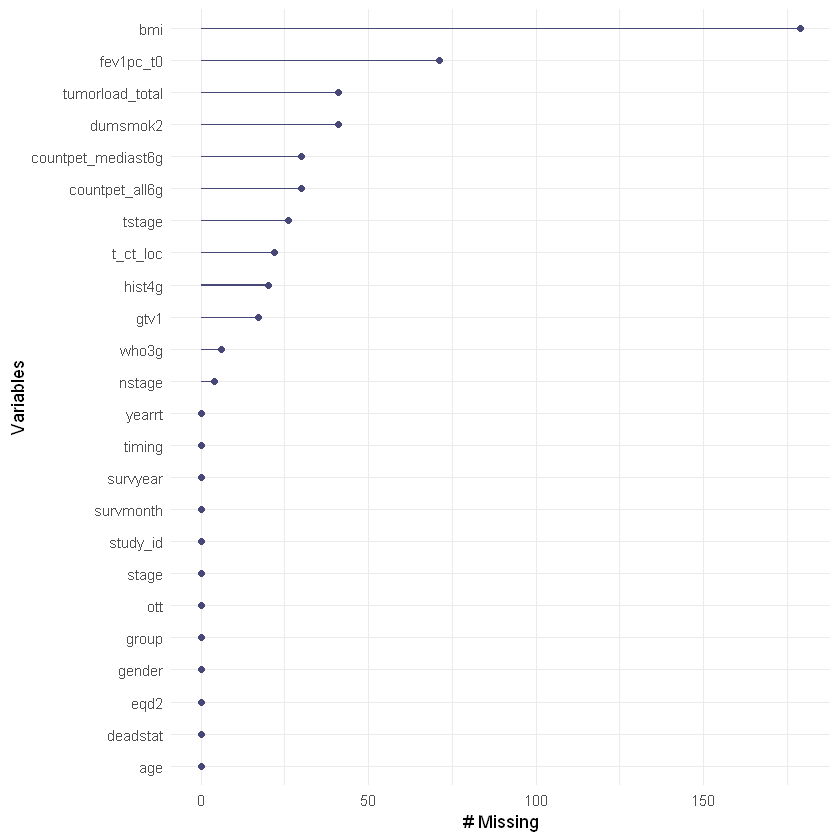

In [178]:
gg_miss_var(lung.data)

The first time this command in a session is run you will get an error message telling you the function cannot be found:
<img src="images/gg_miss_varMissing.png">
This shows that the library containing this function needs to be loaded (the functions we have used already are part of the core R commans). This can be done using the `library()` commnd. Execute the command below and then go back and execute the previous cell. It should now work and give you a chart showing the number of rows where the data us missing for each column.

In [78]:
library(naniar)

At this point we will also add the other libraries we will need throughout this demo

In [179]:
library(ggplot2)
library(survival)
library(survminer)
library(haven)
library(formattable)

### Remove variables with lots of missing data
One way of dealing with missing data is to impute it from the other data. However, this only works well when relatively small volumes of data are missing. As a rule of thumb we will exclude variables where more than 10% of values are missing. From above we know we have 548 patients (rows) and so will exclude variables with more than 55 missing entries. Looking at the above chart we can see this means both the `bmi` (Body Mass Index) and `fev1pc_t0` (Forced Expiratory Volume in 1 minute) variables meet these criteria. 

Its easy to select or exclude columsn or rows from a data frame. We can use the `which` command with an expression to get the column/row index and then select with the `[]` square bracket operators.

The commands below look for the column name 'bmi' and get its index and then select it from the dataframe. Finally we remove the column from the data frame.

In [180]:
ind=which(names(lung.data) == 'bmi')
'Column index:'
print(ind)
'Column values rows 1 -> 10:'
lung.data[1:10,ind]
lung.data=lung.data[,-ind]

[1] "Column index:"

[1] 5


[1] "Column values rows 1 -> 10:"

[1] 22,9938271604938 28,515625        25,1278305332359 28,7267877295578
 [5] 20,3244382551093 21,5138585105239 23,3886865581877 21,4902855137933
 [9] 22,9209710743802 <NA>            
318 Levels: 14,3425723403492 15,9438775510204 ... 41,015625

Check the columns in the data frame again to confirm the 'bmi' column is no longer present

In [181]:
names(lung.data)

[1] "study_id"           "gender"             "age"               
 [4] "who3g"              "fev1pc_t0"          "dumsmok2"          
 [7] "t_ct_loc"           "hist4g"             "countpet_all6g"    
[10] "countpet_mediast6g" "tstage"             "nstage"            
[13] "stage"              "timing"             "group"             
[16] "yearrt"             "eqd2"               "ott"               
[19] "gtv1"               "tumorload_total"    "survmonth"         
[22] "survyear"           "deadstat"

Repeat the process for the FEV variable and check missing data values again.

[1] "study_id"           "gender"             "age"               
 [4] "who3g"              "dumsmok2"           "t_ct_loc"          
 [7] "hist4g"             "countpet_all6g"     "countpet_mediast6g"
[10] "tstage"             "nstage"             "stage"             
[13] "timing"             "group"              "yearrt"            
[16] "eqd2"               "ott"                "gtv1"              
[19] "tumorload_total"    "survmonth"          "survyear"          
[22] "deadstat"

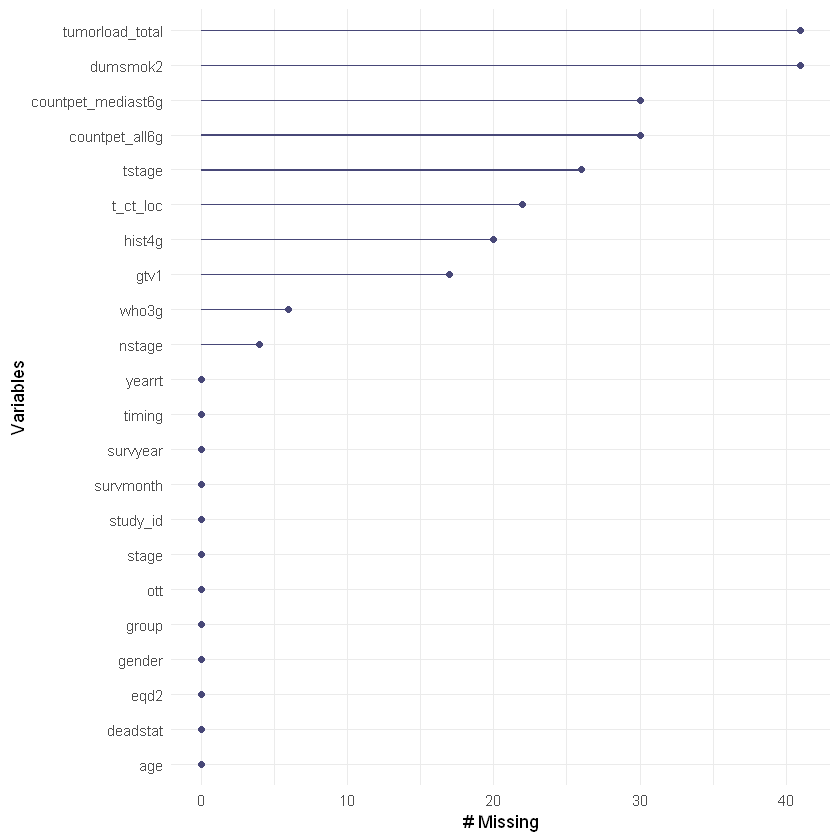

In [182]:
ind=which(names(lung.data) == 'fev1pc_t0')
lung.data=lung.data[,-ind]
names(lung.data)
gg_miss_var(lung.data)

### Filter to variables used in the paper
The model created by the paper uses: age, gender, performance status, tumour volume, positive lymph node status, T stage, overall treatment time, cheomotherapy timing, and EQD2 dose to the tumour to predict patient survival.

We will further filter the variable to only include these columns and assign to a new data frame containing the independent of explanatory factors 'lung.data.ind'

In [183]:
testExpVars=c("gender","age","who3g","countpet_all6g","tstage","nstage","timing","group","eqd2","ott","gtv1")
lung.data.ind=lung.data[,which(names(lung.data) %in% testExpVars)]
head(lung.data.ind)

,gender,age,who3g,countpet_all6g,tstage,nstage,timing,group,eqd2,ott,gtv1
,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>
1,1,"63,1567419575633",2,4,4,4,3,4,"53,125",28,"192,86"
2,2,"66,3052703627652",2,4,4,3,3,4,"55,125",32,"154,93"
3,1,"58,1984941820671",1,1,4,1,3,4,"65,125",32,"85,07"
4,2,"63,7809719370294",2,6,NA,4,3,4,"63,125",36,"98,17"
5,1,"59,4140999315537",1,3,2,3,3,4,"65,125",36,"62,89"
6,1,"49,2594113620808",2,3,NA,3,3,4,"63,125",35,"37,8300018310547"


### Impute remaining missing data values
We will impute the remaining missing values. The simplest way of doing this is to replace all missing values for each variable with the mean or median of that variable. We can do this by looping over each variable (column) and using the `mean()` or `median()` commands. 

1. Loop over each column using its index
2. Check if there is any missing data by summing the number of N/A entries for each column using `is.na()`
3. Replace the rows in that column where the entry is N/A with the median

Note that there are many more sophistoicated imputation techniques available. 

In [187]:
for(i in 1:ncol(lung.data.ind)){
  if(sum(is.na(lung.data.ind[,i]))>0){
    lung.data.ind[is.na(lung.data.ind[,i]),i]=median(lung.data.ind[,i],na.rm=TRUE)
  }
}

This gives an error on the first run through:
<img src="images/factorError.png">
This error is caused by trying to find the median of a factor - a categorical variable for which the concept of median has no meaning. We can check which by referring to the output of the `head()` command above. It is unlikely that 'age', 'eqd2' and 'gtv1' are supposed to be an ordinal variables. Again looking at the output of `head()` we can see that, probably as the data originates in Europe, the decimal points have been written in the csv as commas. We need to process the data to clean this up. We can convert these to numeric types.

In [186]:
lung.data.ind$age=as.numeric(gsub(',','.',lung.data.ind$age))
lung.data.ind$eqd2=as.numeric(gsub(',','.',lung.data.ind$eqd2))
lung.data.ind$gtv1=as.numeric(gsub(',','.',lung.data.ind$gtv1))
head(lung.data.ind)

,gender,age,who3g,countpet_all6g,tstage,nstage,timing,group,eqd2,ott,gtv1
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1,63.15674,2,4,4,4,3,4,53.125,28,192.86
2,2,66.30527,2,4,4,3,3,4,55.125,32,154.93
3,1,58.19849,1,1,4,1,3,4,65.125,32,85.07
4,2,63.78097,2,6,3,4,3,4,63.125,36,98.17
5,1,59.41410,1,3,2,3,3,4,65.125,36,62.89
6,1,49.25941,2,3,3,3,3,4,63.125,35,37.83


Try the imputation step above again and check to see if there are any missing data now

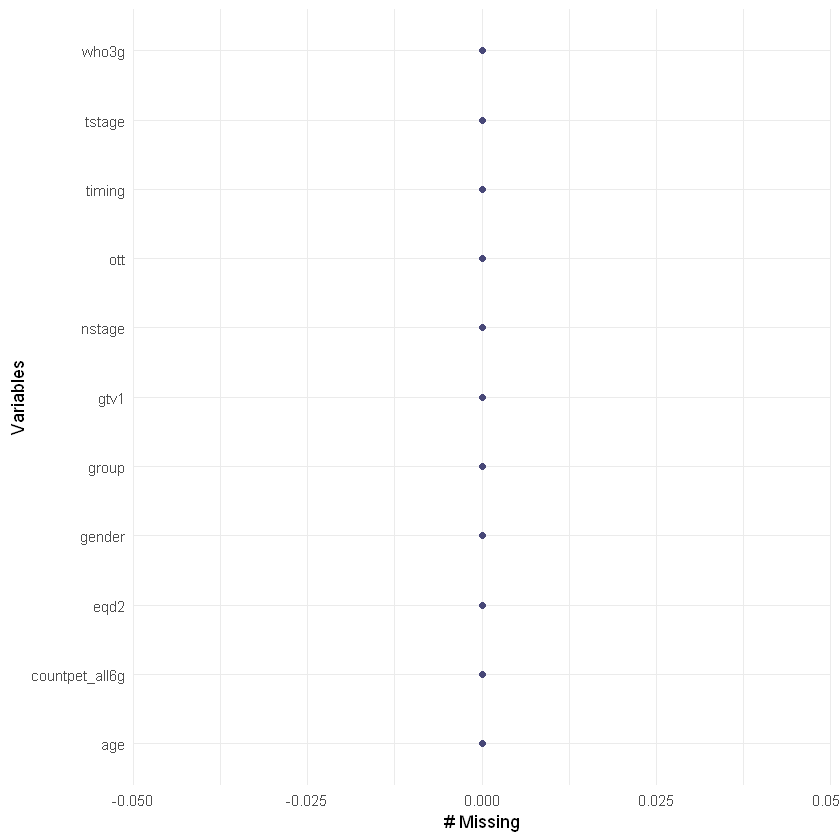

In [188]:
gg_miss_var(lung.data.ind)

We then need to change those variables that should be categorical and ordinal data type as necessary. An ordinal variable is a categorical variable in which the different categories are ordered (e.g. T Stage 1< 2 < 3 < 4). Ordinal variables can be assigned by specifying the order as part of the argument to the `factor()` function. Check the output of the head function again to notice the difference between nominal categorical (unordered) **\<fct\>** and ordinal **\<ord\>** variable types. You can refer to the variable descriptions given with the data on cancerdata.org to understand how the data is coded (e.g. N stage is coded as 1=N0, 2=N1, 3=N2, 4=N3, 5=Nx).

In [189]:
lung.data.ind$gender=factor(lung.data.ind$gender)
lung.data.ind$who3g=factor(lung.data.ind$who3g, order=T, levels=c(0,1,2,3,4))
lung.data.ind$tstage=factor(lung.data.ind$tstage, order=T, levels=c(0,1,2,3,4))
lung.data.ind$nstage=factor(lung.data.ind$nstage, order=T, levels=c(0,1,2,3,4))
lung.data.ind$timing=factor(lung.data.ind$timing)
head(lung.data.ind)

,gender,age,who3g,countpet_all6g,tstage,nstage,timing,group,eqd2,ott,gtv1
,<fct>,<dbl>,<ord>,<dbl>,<ord>,<ord>,<fct>,<int>,<dbl>,<int>,<dbl>
1,1,63.15674,2,4,4,4,3,4,53.125,28,192.86
2,2,66.30527,2,4,4,3,3,4,55.125,32,154.93
3,1,58.19849,1,1,4,1,3,4,65.125,32,85.07
4,2,63.78097,2,6,3,4,3,4,63.125,36,98.17
5,1,59.41410,1,3,2,3,3,4,65.125,36,62.89
6,1,49.25941,2,3,3,3,3,4,63.125,35,37.83


## Dependent variables
These variables are the explanatory variables that we hope to use to predict outcome. The dependent outcome we have in this dataset is survival time (alongside censoring information). 

We can examine the Kaplan-Meier survival curve using the `Surv()` and `survfit()` functions from the 'survial' package:
1. Identify and extract the columns containing the survival and vital status data in the original dataset
2. Clean the data as necessary
3. Create and plot the survival object

In [190]:
lung.data.dep=lung.data[,which(names(lung.data) %in% c("survmonth","deadstat"))]
lung.data.dep$survmonth=as.numeric(gsub(',','.',lung.data.dep$survmonth))
head(lung.data.dep)

,survmonth,deadstat
,<dbl>,<int>
1,16.919918,1
2,5.125257,1
3,57.960000,0
4,7.425051,1
5,16.689938,1
6,22.012320,1


### Survival analysis
Build survival model and check survival curve. Data is plotted using the `ggsurvplot()` function from the 'survminer' package.

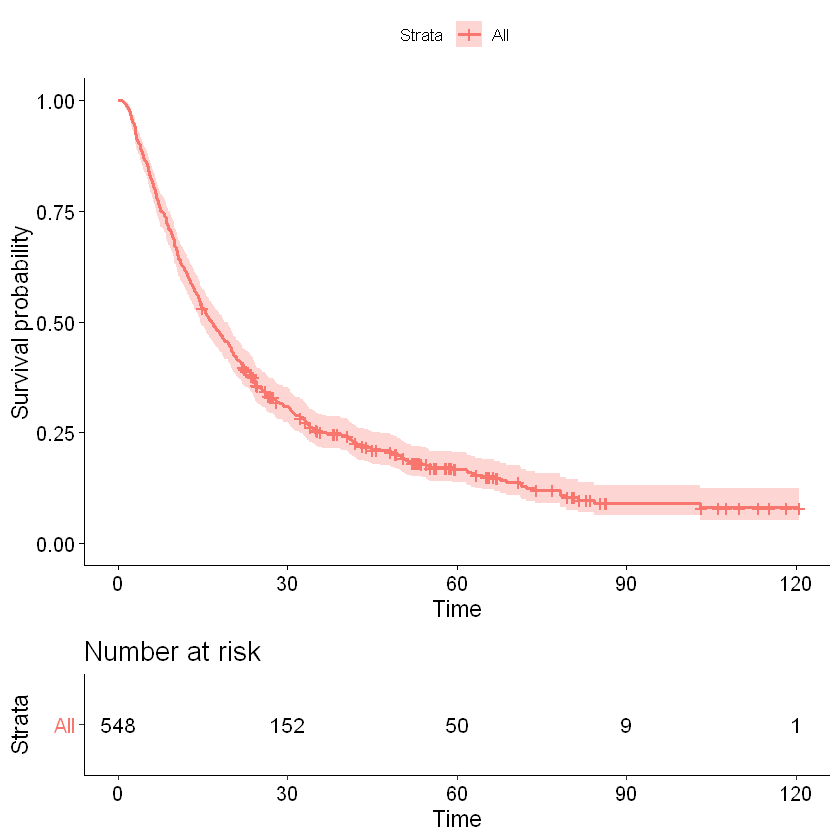

In [191]:
lung.survial=Surv(as.numeric(lung.data.dep$survmonth),lung.data.dep$deadstat)
ggsurvplot(survfit(lung.survial~1,data=lung.data.ind),data=lung.data,risk.table=TRUE)

We can then assess the imfluence of different explanatory factors on patient survival by:
1. Plotting different survival curves for patient subgroups
2. Undertaking a survival analysis

Below we both use the Cox proportional hazards model to estimate the hazard ratios associated with the each factor, and plot K-M curves dichotimised on different explanatory variables

The cox model is run using the `coxph()` function from the 'survial' package. This can be univariable (ie assessing the impact of only 1 factor at a time). Below we see how we can do this for patient tumour volume. This shows us that there is a significant hazard ratio of 1.001 (i.e. increased hazard of death from baseline risk) per 1cm3 increase in GTV volume.  


In [192]:
lung.uniCox=coxph(lung.survial~gtv1,data=lung.data.ind)
print(summary(lung.uniCox))

Call:
coxph(formula = lung.survial ~ gtv1, data = lung.data.ind)

  n= 548, number of events= 456 

          coef exp(coef)  se(coef)     z Pr(>|z|)   
gtv1 0.0012967 1.0012976 0.0004024 3.223  0.00127 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     exp(coef) exp(-coef) lower .95 upper .95
gtv1     1.001     0.9987     1.001     1.002

Concordance= 0.572  (se = 0.016 )
Likelihood ratio test= 9.07  on 1 df,   p=0.003
Wald test            = 10.39  on 1 df,   p=0.001
Score (logrank) test = 10.45  on 1 df,   p=0.001



If we dicotomise GTV volume on some threshold (e.g. mean, median, or an absolute value of interest) we can then plot 2 K-M curves, one for patients with GTV volume smaller than the threshold vs patinets above this threshold. As expected, we see that high risk patients with larger GTV volume do worse. 

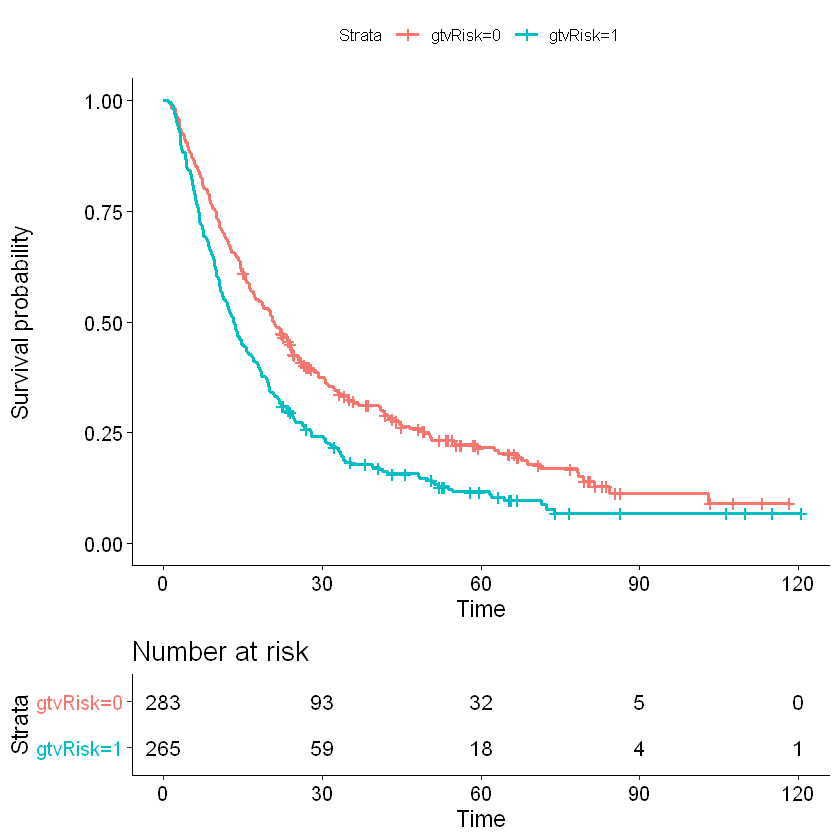

In [193]:
lung.data.dichot=lung.data.ind
lung.data.dichot$gtvRisk = rep(0,nrow(lung.data.ind))
lung.data.dichot$gtvRisk[which(lung.data.dichot$gtv1 > median(lung.data.dichot$gtv1))]=1
ggsurvplot(survfit(lung.survial~gtvRisk,data=lung.data.dichot),data=lung.data.dichot,risk.table=TRUE)

We can undertake univariable analysis for each variable we want to consider as part of a loop. For display reasons we assign a new data frame and extract the hazard and associated p-value to this for display once the loop has completed. As a technical note: where we consider ordinal factors, the cox model will give linear, quadratic and cubic estimates of how the hazard ratio changes with different factor levels with respect to the reference (e.g. lowest) level. Categorical variable will give one estimate per level (again, against a  reference). In the below example we take the linear estimate for ordinal variables. For simplicity of code we only include the first level estimate for the categorical 'timing' (timing of chemotherapy) in the display table. As an exercise you can modify the code below to also include the other factor levels.

In [194]:
analysis.results = data.frame(variable=character(ncol(lung.data.ind)),univariableHR=numeric(ncol(lung.data.ind)),
                            univariableP=numeric(ncol(lung.data.ind)),stringsAsFactors = FALSE)
for(i in 1:ncol(lung.data.ind)){
  lung.uniCox=coxph(as.formula(paste("lung.survial~",names(lung.data.ind)[i])),data=lung.data.ind)
  analysis.results$variable[i]=toString(names(lung.data.ind)[i])
  analysis.results$univariableHR[i]=summary(lung.uniCox)$coefficients[1,2]
  analysis.results$univariableP[i]=summary(lung.uniCox)$coefficients[1,5]
}
formattable(analysis.results)

variable,univariableHR,univariableP
<chr>,<dbl>,<dbl>
gender,0.8375060,8.534323e-02
age,1.0098813,5.750249e-02
who3g,2.8376096,2.213483e-05
countpet_all6g,1.1005999,8.093132e-04
tstage,1.6526899,3.684927e-01
nstage,0.4345209,4.902704e-01
timing,0.8220829,1.670883e-01
group,0.8461808,3.851740e-04
eqd2,0.9847232,2.071315e-02


Finally we will undertake a multivariable analysis and see how these values compare to the univariable estimations

In [195]:
lung.multiCox=coxph(lung.survial~gender+age+who3g+countpet_all6g+tstage+nstage+timing+group+
                      eqd2+ott+gtv1,data=lung.data.ind)
print(lung.multiCox)

Call:
coxph(formula = lung.survial ~ gender + age + who3g + countpet_all6g + 
    tstage + nstage + timing + group + eqd2 + ott + gtv1, data = lung.data.ind)

                     coef  exp(coef)   se(coef)      z        p
gender2        -0.3135094  0.7308775  0.1086960 -2.884 0.003923
age             0.0045056  1.0045157  0.0055778  0.808 0.419228
who3g.L         0.9570824  2.6040876  0.2608234  3.669 0.000243
who3g.Q        -0.1323547  0.8760302  0.3838418 -0.345 0.730233
who3g.C                NA         NA  0.0000000     NA       NA
who3g^4                NA         NA  0.0000000     NA       NA
countpet_all6g  0.1685331  1.1835674  0.0424221  3.973 7.10e-05
tstage.L        0.4464120  1.5626952  0.5769140  0.774 0.439053
tstage.Q       -0.1946264  0.8231422  0.4606969 -0.422 0.672689
tstage.C       -0.1593741  0.8526773  0.2948078 -0.541 0.588781
tstage^4               NA         NA  0.0000000     NA       NA
nstage.L       -0.9159271  0.4001455  1.2356879 -0.741 0.458555
nstage.Q 

We can then add these data to the table to enable easy comparison

In [196]:
multivariableHR=numeric(ncol(lung.data.ind))
multivariableP=numeric(ncol(lung.data.ind))

multivariableHR[1]=summary(lung.multiCox)$coefficients[1,2]
multivariableP[1]=summary(lung.multiCox)$coefficients[1,5]

multivariableHR[2]=summary(lung.multiCox)$coefficients[2,2]
multivariableP[2]=summary(lung.multiCox)$coefficients[2,5]

multivariableHR[3]=summary(lung.multiCox)$coefficients[3,2]
multivariableP[3]=summary(lung.multiCox)$coefficients[3,5]

multivariableHR[4]=summary(lung.multiCox)$coefficients[7,2]
multivariableP[4]=summary(lung.multiCox)$coefficients[7,5]

multivariableHR[5]=summary(lung.multiCox)$coefficients[8,2]
multivariableP[5]=summary(lung.multiCox)$coefficients[8,5]

multivariableHR[6]=summary(lung.multiCox)$coefficients[12,2]
multivariableP[6]=summary(lung.multiCox)$coefficients[12,5]

multivariableHR[7]=summary(lung.multiCox)$coefficients[16,2]
multivariableP[7]=summary(lung.multiCox)$coefficients[16,5]

multivariableHR[8]=summary(lung.multiCox)$coefficients[18,2]
multivariableP[8]=summary(lung.multiCox)$coefficients[18,5]

multivariableHR[9]=summary(lung.multiCox)$coefficients[19,2]
multivariableP[9]=summary(lung.multiCox)$coefficients[19,5]

multivariableHR[10]=summary(lung.multiCox)$coefficients[20,2]
multivariableP[10]=summary(lung.multiCox)$coefficients[20,5]

multivariableHR[11]=summary(lung.multiCox)$coefficients[21,2]
multivariableP[11]=summary(lung.multiCox)$coefficients[21,5]

analysis.results$multivariableHR=multivariableHR
analysis.results$multivariableP=multivariableP

formattable(analysis.results)

variable,univariableHR,univariableP,multivariableHR,multivariableP
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
gender,0.8375060,8.534323e-02,0.7308775,3.923127e-03
age,1.0098813,5.750249e-02,1.0045157,4.192284e-01
who3g,2.8376096,2.213483e-05,2.6040876,2.430586e-04
countpet_all6g,1.1005999,8.093132e-04,1.1835674,7.104249e-05
tstage,1.6526899,3.684927e-01,1.5626952,4.390532e-01
nstage,0.4345209,4.902704e-01,0.4001455,4.585549e-01
timing,0.8220829,1.670883e-01,1.1191121,7.682017e-01
group,0.8461808,3.851740e-04,0.8649911,4.407862e-01
eqd2,0.9847232,2.071315e-02,0.9815706,2.267202e-02


As can be seen there are now differences between the hazard ratio estimations for each factor. In particular:
* Age is identified as much less likely to have significant influence on survival in the multivariable analysis
* Overall treatment time is found to be more influential in the multivariable analysis (whereas previously we might have dismissed this as a relevent factor).